In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import os

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Constants (should match training config)
MAX_LEN = 128
MODEL_PATH = './roberta_sentiment_model.pt'
TEST_SAMPLE_SIZE = 7500
BATCH_SIZE = 32
MODEL_NAME = 'roberta-base'

In [4]:
# 1. Load IMDB Dataset
def load_imdb_sample(n_samples=TEST_SAMPLE_SIZE):
    data = pd.read_csv('../../data/raw/IMDB Dataset.csv')
    data['label'] = data['sentiment'].map({'negative': 0, 'positive': 1})
    df = pd.DataFrame({
        'text': data['review'],
        'label': data['label']
    })
    return df.sample(n_samples, random_state=42)

In [5]:
# 2. Load Model Function
def load_sentiment_model(model_path, model_name):
    """Load the trained RoBERTa model and tokenizer"""
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)
    
    # Load the trained weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    
    return tokenizer, model

In [6]:
# 3. Prediction Function with Confidence
def predict_sentiment(text, tokenizer, model):
    """Predict sentiment with confidence score"""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=MAX_LEN, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        confidence, prediction = torch.max(probabilities, dim=1)
    
    sentiment = "positive" if prediction.item() == 1 else "negative"
    return sentiment, confidence.item()

In [7]:
# 4. Comprehensive Evaluation Function
def evaluate_model(model, tokenizer, test_texts, test_labels, batch_size=BATCH_SIZE):
    """
    Evaluate model and print metrics including:
    - F1 score, accuracy, precision, recall
    - Confusion matrix
    - Classification report
    """
    # Tokenize test data
    encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=MAX_LEN)
    input_ids = torch.tensor(encodings['input_ids'])
    attention_mask = torch.tensor(encodings['attention_mask'])
    labels = torch.tensor(test_labels.tolist())
    
    # Create dataset and dataloader
    dataset = TensorDataset(input_ids, attention_mask, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    
    # Get predictions
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    
    # Print metrics
    print("\n" + "="*50)
    print(f"Model Evaluation Metrics (on {len(all_labels)} samples)")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': cm
    }

Loading RoBERTa model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adity\AppData\Local\Temp\ipykernel_11760\2167342115.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode un


Loading IMDB dataset (7500 samples)...

Evaluating RoBERTa model on IMDB dataset...

Model Evaluation Metrics (on 7500 samples)
Accuracy: 0.9129
F1 Score: 0.9137
Precision: 0.9160
Recall: 0.9114


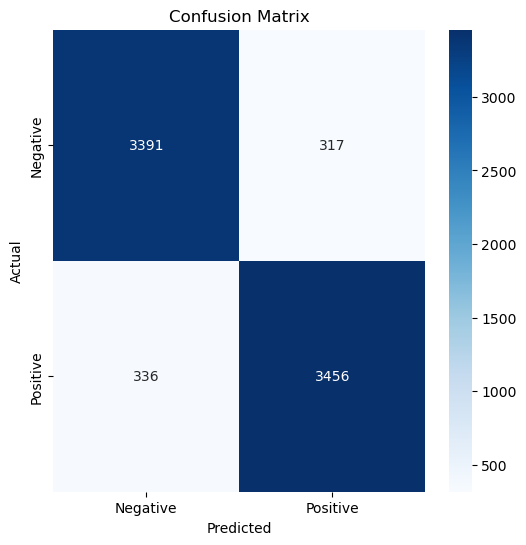


Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.91      0.91      3708
    Positive       0.92      0.91      0.91      3792

    accuracy                           0.91      7500
   macro avg       0.91      0.91      0.91      7500
weighted avg       0.91      0.91      0.91      7500


Example Predictions from IMDB dataset:
Text: In New York, in a morning close to Christmas, an upper class father an...
Sentiment: negative (Confidence: 0.99)
--------------------------------------------------------------------------------
Text: Guns blasting, buildings exploding, cars crashing, and that's just the...
Sentiment: positive (Confidence: 0.99)
--------------------------------------------------------------------------------
Text: My wife and I watched this movie because we plan to visit Sicily and S...
Sentiment: negative (Confidence: 0.99)
--------------------------------------------------------------------------------

Evaluati

In [8]:
# 5. Main Execution
if __name__ == "__main__":
    # Load the model
    print("Loading RoBERTa model...")
    tokenizer, model = load_sentiment_model(MODEL_PATH, MODEL_NAME)
    
    # Load IMDB dataset
    print(f"\nLoading IMDB dataset ({TEST_SAMPLE_SIZE} samples)...")
    imdb_df = load_imdb_sample()
    
    # Split into text and labels
    test_texts = imdb_df['text']
    test_labels = imdb_df['label']
    
    # Run evaluation
    print("\nEvaluating RoBERTa model on IMDB dataset...")
    metrics = evaluate_model(model, tokenizer, test_texts, test_labels)
    
    # Example predictions
    print("\nExample Predictions from IMDB dataset:")
    sample_texts = imdb_df.sample(3, random_state=42)['text'].tolist()
    for text in sample_texts:
        sentiment, confidence = predict_sentiment(text, tokenizer, model)
        print(f"Text: {text[:70]}...")
        print(f"Sentiment: {sentiment} (Confidence: {confidence:.2f})")
        print("-" * 80)
    
    print("\nEvaluation complete!")

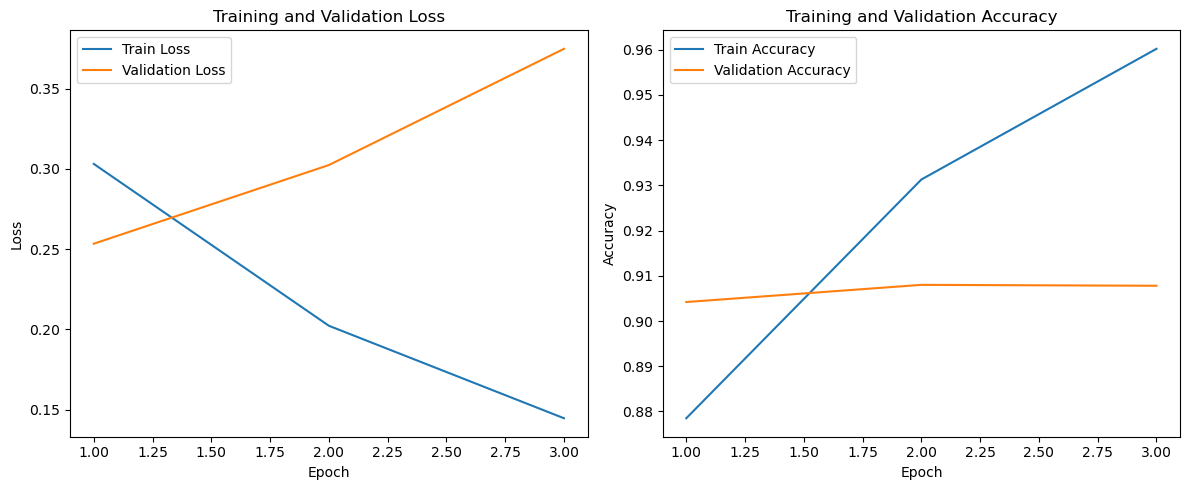

In [9]:
# Additional Analysis: Training Log Visualization
def plot_training_log(log_path='training_log.txt'):
    """Visualize training progress from log file"""
    if not os.path.exists(log_path):
        print(f"Training log file not found at {log_path}")
        return
    
    df = pd.read_csv(log_path)
    
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(df['Epoch'], df['Train Loss'], label='Train Loss')
    plt.plot(df['Epoch'], df['Val Loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(df['Epoch'], df['Train Acc'], label='Train Accuracy')
    plt.plot(df['Epoch'], df['Val Acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Run the visualization
plot_training_log()

In [10]:
# Error Analysis: Examine misclassified examples
def analyze_errors(model, tokenizer, test_texts, test_labels, n_samples=5):
    """Show examples where the model made incorrect predictions"""
    # Get predictions for all samples
    encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=MAX_LEN)
    input_ids = torch.tensor(encodings['input_ids'])
    attention_mask = torch.tensor(encodings['attention_mask'])
    labels = torch.tensor(test_labels.tolist())
    
    dataset = TensorDataset(input_ids, attention_mask, labels)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
    
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
    
    # Find misclassified examples
    incorrect_indices = [i for i, (pred, true) in enumerate(zip(all_preds, test_labels)) if pred != true]
    
    print(f"\nAnalyzing {min(n_samples, len(incorrect_indices))} misclassified examples:")
    
    for i in incorrect_indices[:n_samples]:
        text = test_texts.iloc[i]
        true_label = 'positive' if test_labels.iloc[i] == 1 else 'negative'
        pred_label, confidence = predict_sentiment(text, tokenizer, model)
        
        print(f"\nTrue Label: {true_label}")
        print(f"Predicted: {pred_label} (Confidence: {confidence:.2f})")
        print(f"Text: {text[:200]}...")
        print("-" * 80)

# Run error analysis
analyze_errors(model, tokenizer, test_texts, test_labels)


Analyzing 5 misclassified examples:

True Label: positive
Predicted: negative (Confidence: 0.95)
Text: I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ev...
--------------------------------------------------------------------------------

True Label: positive
Predicted: negative (Confidence: 0.99)
Text: The production quality, cast, premise, authentic New England (Waterbury, CT?) locale and lush John Williams score should have resulted in a 3-4 star collectors item. Unfortunately, all we got was a pa...
--------------------------------------------------------------------------------

True Label: negative
Predicted: positive (Confidence: 0.81)
Text: I'm writing this note as a chess player as well as as a movie viewer. I watched the 1997 Kasparov-Deep Blue games on the Internet. I know something about the issues that were raised. Other che